# DATASET EXTRACTION

In [1]:
dataset_Auronzo <- read.csv("dataset/Auronzo.csv", header = FALSE, sep = ";")
head(dataset_Auronzo, n = 10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ARPAV Centro Meteorologico di Teolo,,,,,,,,,,,,,
2,,,,,,,,,,,,,,
3,Bollettino dei valori mensili pluriennali,,,,,,,,,,,,,
4,,,,,,,,,,,,,,
5,Stazione Auronzo,,,,,,,,,,,,,
6,Coordinata X 1762629 Gauss-Boaga fuso,,,,,,,,,,,,,
7,Coordinata Y 5161582 Ovest (EPSG:3003),,,,,,,,,,,,,
8,Quota della stazione 849 m s.l.m.,,,,,,,,,,,,,
9,Parametro Precipitazione (mm) somma,,,,,,,,,,,,,


In [2]:
extract_dataset <- function(directory, city_list){

    dataset <- list()
    
    for (city in city_list){
        dataset_city <- read.csv(paste0(directory, "/", city,".csv"), header = FALSE, sep = ";")
        metrics <- c()
        
        extracted_ds <- c()
        for (n_line in 1:nrow(dataset_city)){
            
            for (element in dataset_city[n_line,]){
                
                if (startsWith(element, "Stazione")){
                    metric <- dataset_city[[(n_line+4),1]]
                    metric <- iconv(metric, from = "", to = "UTF-8", sub = "_")
                    
                    matrix_measure <- data.frame(data = matrix(dataset_city[(n_line + 9): (n_line + 29), 2:13]), skipped_days = matrix(dataset_city[(n_line + 52): (n_line + 72), 2:13]))
                    names(matrix_measure) <- c(metric, paste0(metric,"_days"))
                    extracted_ds <- c(extracted_ds, matrix_measure)
                }
            }
        }
        dataset <- append(dataset, setNames(list(extracted_ds), city))
    }
    return(dataset)
}


In [187]:
extract_dataset <- function(directory, city_list) {

  # Funzione interna per convertire valori in numerico, sostituendo NA con 0
  convert_numeric <- function(x) {
    num <- as.numeric(trimws(x))
    if (is.na(num)) num <- 0
    return(num)
  }

  dataset <- list()
  months <- c('GEN', 'FEB', 'MAR', 'APR', 'MAG', 'GIU', 'LUG', 'AGO', 'SET', 'OTT', 'NOV', 'DIC')

  for (city in city_list) {
    dataset_city <- read.csv(
      paste0(directory, "/", city, ".csv"),
      header = FALSE,
      sep = ";",
      stringsAsFactors = FALSE
    )

    extracted_ds <- list()

    for (n_line in 1:nrow(dataset_city)) {
      for (element in dataset_city[n_line, ]) {

        if (startsWith(element, "Stazione")) {
          metric <- dataset_city[[(n_line + 4), 1]]
          metric <- iconv(metric, from = "", to = "UTF-8", sub = "_")

          data_matrix <- as.matrix(dataset_city[(n_line + 9):(n_line + 39), 2:13])
          skipped_days_matrix <- as.matrix(dataset_city[(n_line + 52):(n_line + 82), 2:13])

          n_rows <- min(nrow(data_matrix), nrow(skipped_days_matrix))
          years <- 1994:(1994 + n_rows - 1)

          data_matrix <- data_matrix[1:n_rows, , drop = FALSE]
          skipped_days_matrix <- skipped_days_matrix[1:n_rows, , drop = FALSE]

          rownames(data_matrix) <- years
          rownames(skipped_days_matrix) <- years
          colnames(data_matrix) <- months[1:ncol(data_matrix)]
          colnames(skipped_days_matrix) <- months[1:ncol(skipped_days_matrix)]

          extracted_ds[[metric]] <- data_matrix
          extracted_ds[[paste0(metric, "_days")]] <- skipped_days_matrix
        }
      }
    }

    dataset[[city]] <- extracted_ds
  }

  return(dataset)
}


In [188]:
dataset <- extract_dataset("dataset", c("Auronzo", "Porto_Tolle_-_Pradon", "Roverchiara", "Castelfranco_Veneto"))

In [198]:
dataset[["Auronzo"]][["Parametro Temperatura aria a 2m (_C) media delle massime"]][,1]

1994   1995   1996   1997   1998   1999   2000   2001   2002   2003   2004 
 "3.7"  "1.7"  "2.6"  "4.6"  "3.4"  "3.2"  "2.3"  "2.6"  "2.3"    "3"  "1.5" 
  2005   2006   2007   2008   2009   2010   2011   2012   2013   2014   2015 
 "1.4"  "1.2"  "4.6"  "3.2"    "2"  "0.7"  "2.5"  "3.2"  "3.6"  "3.5"  "3.8" 
  2016   2017   2018   2019   2020   2021   2022   2023   2024 
   "3"  "2.1"  "3.8"  "2.9"  "3.8" "-0.2"  "3.4"  "2.9"  "3.7"

Warning message in mean.default(Tmax_gen, Tmin_gen):
“argument is not numeric or logical: returning NA”


ERROR: Error in xy.coords(x, y): 'x' and 'y' lengths differ


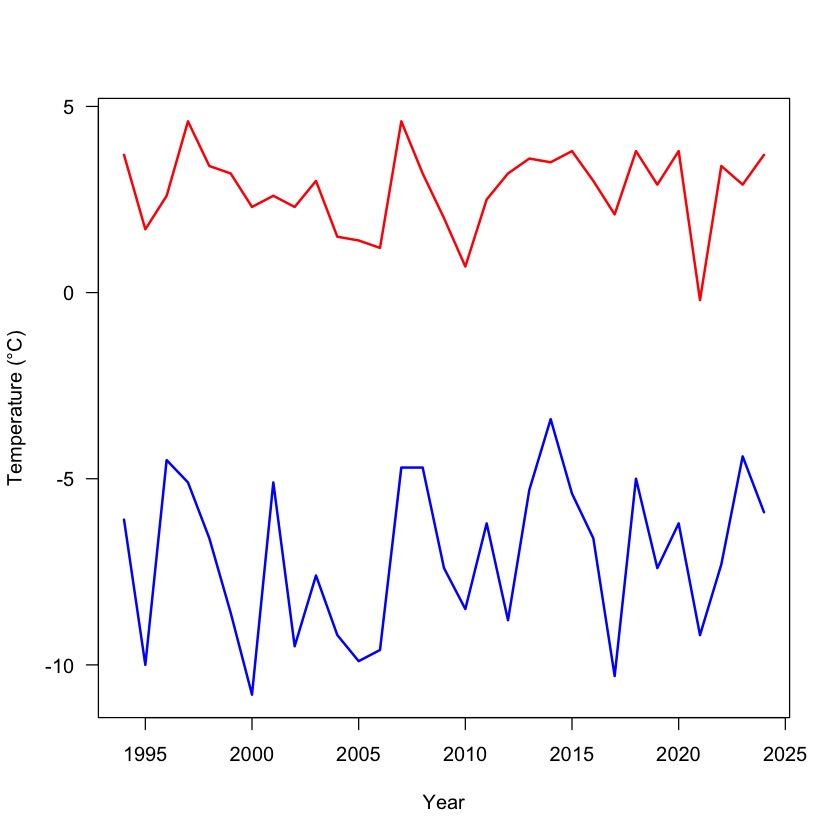

In [203]:
Tmin_gen <- dataset[["Auronzo"]][["Parametro Temperatura aria a 2m (_C) media delle minime"]][,1]
Tmax_gen <- dataset[["Auronzo"]][["Parametro Temperatura aria a 2m (_C) media delle massime"]][,1]
Tmean_gen <- mean(Tmax_gen, Tmin_gen)

Tmin_gen <- suppressWarnings(as.numeric(Tmin_gen))
Tmax_gen <- suppressWarnings(as.numeric(Tmax_gen))

n <- min(length(Tmin_gen), length(Tmax_gen))
Tmin_gen <- Tmin_gen[1:n]
Tmax_gen <- Tmax_gen[1:n]
years <- 1994:(1994 + n - 1)

valid_idx <- !is.na(Tmin_gen) & !is.na(Tmax_gen)
years <- years[valid_idx]
Tmin_gen <- Tmin_gen[valid_idx]
Tmax_gen <- Tmax_gen[valid_idx]

plot(years, Tmin_gen, type = "n", ylim = range(c(Tmin_gen, Tmax_gen)), xlab = "Year", ylab = "Temperature (°C)", las = 1)

lines(years, Tmin_gen, col = "blue", lwd = 2, lty = 1)
lines(years, Tmax_gen, col = "red", lwd = 2, lty = 1)
lines(years, Tmean_gen, col = "green", lwd = 2, lty = 1)

points(years, Tmin_gen, col = "blue", pch = 16)
points(years, Tmax_gen, col = "red", pch = 17)
points(years, Tmean_gen, col = "green", pch = 18)

legend("topright", legend = c("Tmin", "Tmax"),
       col = c("blue", "red"), lty = c(1,2), pch = c(16,17),
       lwd = 2, bty = "n")
